<a href="https://colab.research.google.com/github/sethcoast/attention/blob/main/attention_is_all_you_need.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# what does the architecture look like?

# How has Pytorch changed in the last little while?

# What do I need for all of this?
# 1. Training data
# 2. Model
# 3. Training loop

# This will likely be done in a few separate phases
# 1. Build and validate the model architecture
        # training data?
# 2. Set up training/snapshotting system in GCP


In [3]:
# Import the shit
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.transforms

import numpy as np
import matplotlib.pyplot as plt


# Data

# Model

In [4]:
# Import the shit
import torch
import torch.nn as nn
import torch.utils.data


# Feed forward block (sublayer)
class FeedForwardBlock(nn.Module):
    def __init__(self, dmodel):
        super(FeedForwardBlock, self).__init__()
        # Define the feed forward network layers
        self.fc1 = nn.Linear(dmodel, dmodel)
        self.fc2 = nn.Linear(dmodel, dmodel)
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU(inplace=True) # inplace = True to save memory

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.dropout(x)

        return x

# Multihead Attention block (Sublayer)
class MultiheadAttentionBlock(nn.Module):
    def __init__(self, dmodel, mask=False):
        super(MultiheadAttentionBlock, self).__init__()
        self.mhAtt = nn.MultiheadAttention(dmodel, 8, dropout=0.1, batch_first=True)
        # look-ahead mask
        # self.att_mask = self.create_look_ahead_mask()

    def forward(self, Q, K, V):
        # print(Q.shape, K.shape, V.shape)
        x = self.mhAtt(query=Q, key=K, value=V, need_weights=False)
        return x[0]

    def create_look_ahead_mask(self, size):
        # todo: double check that this is correct
        mask = torch.triu(torch.ones(size, size), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask

# define the encoder model
class EncoderLayer(nn.Module):
    def __init__(self, dmodel):
        super(EncoderLayer, self).__init__()
        # Define the attention layer
        self.mhaBlock = MultiheadAttentionBlock(dmodel)
        self.ff = FeedForwardBlock(dmodel)
        self.norm = nn.LayerNorm(dmodel)


    def forward(self, x):
        # Multi Head Attention Sublayer()
        out = self.mhaBlock(x, x, x)
        out += x # residual connection
        out = self.norm(out) # normalization

        # Feed Forward Sublayer()
        out2 = self.ff(out)
        out2 += out # residual connection
        out2 = self.norm(out2) # normalization

        return out2

# Decoder Layer
class DecoderLayer(nn.Module):
    def __init__(self, dmodel):
        super(DecoderLayer, self).__init__()
        self.mhaBlock1 = MultiheadAttentionBlock(dmodel, mask=True)
        self.ffBlock = FeedForwardBlock(dmodel)
        self.mhaBlock2 = MultiheadAttentionBlock(dmodel)
        self.norm = nn.LayerNorm(dmodel)

    def forward(self, in_encoding, out_embedding):
        ## Multi Head Attention Sublayer 1 (masked)
        # todo: padding mask?
        decoded = self.mhaBlock1(out_embedding, out_embedding, out_embedding)
        decoded += out_embedding # residual connection
        decoded = self.norm(decoded) # normalization
        ## Multi Head Attention Sublayer 2
        decoded2 = self.mhaBlock1(decoded, in_encoding, in_encoding)
        decoded2 += decoded # residual connection
        decoded2 = self.norm(decoded2) # normalization
        ## Feed Forward Sublayer
        decoded3 = self.ffBlock(decoded2)
        decoded3 += decoded2 # residual connection
        decoded3 = self.norm(decoded3) # normalization

        return decoded3


class TransformerNet(nn.Module):
    # numLayers = 6 by default to mimic the parameters of the paper
    def __init__(self, vocab_size, dmodel, seq_len, numLayers = 6):
        super(TransformerNet, self).__init__()
        # todo: define the positional encoding stuff?
        # Embedding layer
        self.embedding_layer = nn.Embedding(vocab_size, dmodel)
        # Instantiate encoder/decoder layers
        self.encoder_layers = nn.ModuleList()
        for _ in range(numLayers):
            self.encoder_layers.append(EncoderLayer(dmodel))
        self.decoder_layers = nn.ModuleList()
        for _ in range(numLayers):
            self.decoder_layers.append(DecoderLayer(dmodel))
        # Output layer
        self.last = nn.Embedding(vocab_size, dmodel)
        # self.last.weight = torch.nn.Parameter(self.embedding_layer.weight.t()) # todo: double check this
        self.softmax = nn.Softmax(dim=2) # todo: expand dimensionality to get like a 1-hot representation

    # todo: maybe rewrite this eventually
    def forward(self, in_seq, out_seq):
        # todo: Embedding layers (multiply weights by √dmodel (v2))
        # todo: Contatenate input w/ positional encoding (v2)
        # print("in_seq.shape: ", in_seq.shape)
        # Encoder stack
        in_encode = self.embedding_layer(in_seq) # shape = (batch_size, seq_len, dmodel)
        for layer in self.encoder_layers:
            in_encode = layer(in_encode)
        # print("in_encode.shape: ", in_encode.shape)
        # Decoder stack
        out_encode = self.embedding_layer(out_seq)
        for layer in self.decoder_layers:
            out_encode = layer(in_encode, out_encode)
        # print("out_encode.shape: ", out_encode.shape)
        # Output layer
        # Output layer: Reuse embedding weights
        out = torch.matmul(out_encode, self.embedding_layer.weight.transpose(0, 1))

        return out

    def translate(self, src, max_len=50):
        self.eval()  # Set the model to evaluation mode
        src = torch.tensor(src).unsqueeze(0)  # Source sentence tensor

        # out = self.softmax(logits)
        # print(out.shape)

        # Grab the predicted token
        # out = torch.argmax(out, dim=1)



# Dataset

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchtext
import torchvision
import torchvision.transforms
import json

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

In [6]:
from transformers import AutoTokenizer

# Load a pre-trained multilingual tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [7]:
# Tokenize a sentence
english_sentence = "This is an example sentence."
japanese_sentence = "これは例文です。"

# Tokenizing the sentences
tokenized_english = tokenizer.tokenize(english_sentence)
tokenized_japanese = tokenizer.tokenize(japanese_sentence)

print("Tokenized English:", tokenized_english)
print("Tokenized Japanese:", tokenized_japanese)

Tokenized English: ['This', 'is', 'an', 'example', 'sentence', '.']
Tokenized Japanese: ['これは', '例', '文', 'で', '##す', '。']


In [8]:
class EnJpTranslationDataset(Dataset):
    def __init__(self, en_sentences, jp_sentences, tokenizer, max_length=128):
        self.en_sentences = en_sentences
        self.jp_sentences = jp_sentences
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.en_sentences)

    def __getitem__(self, idx):
        # Get the English and Japanese sentences
        en_s = self.en_sentences[idx]
        jp_s = self.jp_sentences[idx]

        # Encode the English sentence (source)
        source_encoded = self.tokenizer.encode_plus(
            en_s,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Encode the Japanese sentence (target)
        # Note: Depending on your model, you might need to add special tokens manually
        target_encoded = self.tokenizer.encode_plus(
            jp_s,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Return source and target as a dictionary
        # Flatten the tensors to remove unnecessary batch dimension added by return_tensors='pt'
        return {
            'source_input_ids': source_encoded['input_ids'].squeeze(0),
            'source_attention_mask': source_encoded['attention_mask'].squeeze(0),
            'target_input_ids': target_encoded['input_ids'].squeeze(0),
            'target_attention_mask': target_encoded['attention_mask'].squeeze(0),
        }


# Train Loop

## Set up Data

In [9]:
from tqdm import tqdm

In [10]:
# Set seeds
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [11]:
# Data loading
drive_dir = 'drive/MyDrive/'
data_dir = 'drive/MyDrive/data/ja-en/split/'
file_path = data_dir + 'test' # todo: change this when you want to use a different dataset
# split english and japanese sentences into separate lists
en_sentences, jp_sentences = [], []
with open(file_path, 'r', encoding='utf-8') as file:
    for i, line in enumerate(file):
        en, ja = line.strip().split('\t')
        en_sentences.append(en)
        jp_sentences.append(ja)

In [12]:
train_data = EnJpTranslationDataset(en_sentences, jp_sentences, tokenizer)

# Move pytorch dataset into dataloader.
train_batch_size = 32
train_loader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
print(f'Created `train_loader` with {len(train_loader)} batches!')

Created `train_loader` with 63 batches!


In [13]:
# train_data[0]

## Set up Model

In [14]:
tokenizer.vocab_size

119547

In [15]:
# Model, Loss Function, Optimizer
dmodel = 512
H = 6
seq_len = train_data.max_length
vocab_size = tokenizer.vocab_size
model = TransformerNet(vocab_size, dmodel, seq_len, H)
criterion = nn.CrossEntropyLoss()  # todo: I'm pretty sure this is correct, but double check
optimizer = optim.Adam(model.parameters(), lr=0.001) # todo: double check paper params

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)


cuda


In [16]:
train_losses = []
val_losses = []

validation_accs = []
accuracies = []

In [17]:
# Training Loop
num_epochs = 5  # Example number of epochs
for epoch in range(num_epochs):
    loop = tqdm(total=len(train_loader), position=0, leave=False)
    model.train()  # Set the model to training mode
    for batch_idx, train_dict in enumerate(train_loader):
        source_seq = train_dict['source_input_ids']
        target_seq = train_dict['target_input_ids']

        source_seq, target_seq = source_seq.to(device), target_seq.to(device)

        # Forward pass
        outputs = model(source_seq, target_seq)
        # print(outputs.shape)
        # print(outputs)
        # print(target_seq.shape)
        # print(target_seq)
        # print(outputs[0][0].shape)
        # print(outputs[0][0].sum())
        # break
        outputs = outputs.permute(0, 2, 1)

        loss = criterion(outputs, target_seq)

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear gradients from the previous step
        loss.backward()  # Backpropagation
        optimizer.step()  # Apply the gradients


        # if (batch_idx + 1) % 100 == 0:
        #     print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        # Housekeeping
        train_losses.append(loss)
        # accuracy = get_raw_accuracy(y_hat, y_truth)
        mem = torch.cuda.memory_allocated(0) / 1e9
        # accuracies.append(accuracy)
        # loop.set_description('epoch:{}, loss:{:.4f}, accuracy:{:.3f}, mem:{:.2f}'.format(epoch, loss, accuracy, mem))
        loop.set_description('epoch:{}, loss:{:.4f}, mem:{:.2f}'.format(epoch, loss, mem))
        loop.update(1)

    # Validation Loop (cute and optimized)
    # compute the loss for all x, y in val_loader, then get the mean of those losses
    # val = np.mean([criterion(model(x.cuda()), y.cuda().long()).item()
    #                 for x, y in test_loader
    #                 ])
    # val_losses.append((len(train_losses), val))
    # print('\nVal Loss: {:.4f}'.format(val))

    # todo: remove accuracy block?
    # val_acc = np.mean([get_raw_accuracy(model(x.cuda()), y.cuda().long())
    #                 for x, y in test_loader
    #                 ])
    # validation_accs.append((len(accuracies), val_acc))
    # print('\nVal Loss: {:.4f}, Val Accuracy: {:.3f}'.format(val, val_acc))

    loop.close()

    # break

print("Training Complete")

Training Complete


In [18]:
train_losses = [loss.cpu().item() for loss in train_losses]

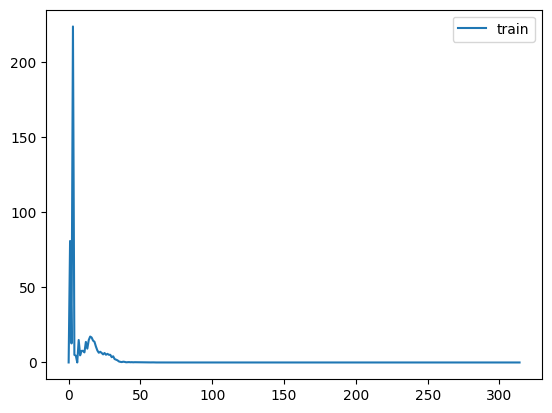

In [19]:
# Show loss curve
# validations is a list of tuples, this unzips it into two lists
# a, b = zip(*val_losses)
plt.plot(train_losses, label='train')
# plt.plot(a, b, label='val')
plt.legend()
plt.show()

In [ ]:
# Save the state dictionary
model_dir = 'drive/MyDrive/model/'
torch.save(model.state_dict(), drive_dir + 'attn.pth')

# Inference

In [ ]:
train_data[0]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

In [ ]:
# Initialize the model
model = TransformerNet(vocab_size, dmodel)

# Load the saved state dictionary
model.load_state_dict(torch.load(model_dir + 'model.pth'))

# Set the model to evaluation mode for inference
model.eval()

TransformerNet(
  (embedding_layer): Linear(in_features=2000, out_features=512, bias=True)
  (encoder_layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (mhaBlock): MultiheadAttentionBlock(
        (mhAtt): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
      )
      (ff): FeedForwardBlock(
        (fc1): Linear(in_features=512, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (relu): ReLU(inplace=True)
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
  )
  (decoder_layers): ModuleList(
    (0-5): 6 x DecoderLayer(
      (mhaBlock1): MultiheadAttentionBlock(
        (mhAtt): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
      )
      (ffBlock): FeedForwardBlock(
        (fc1): Line

In [ ]:
import sentencepiece as spm

In [ ]:
model_dir = 'drive/MyDrive/model/'

In [ ]:
sp_en = spm.SentencePieceProcessor(model_file= model_dir + 'en_bpe.model')
sp_jp = spm.SentencePieceProcessor(model_file= model_dir + 'jp_bpe.model')



In [ ]:
# Decode English sentences
decoded_en = [sp_en.decode(encoded_sentence) for encoded_sentence in encoded_en]

# Decode Japanese sentences
decoded_jp = [sp_jp.decode(encoded_sentence) for encoded_sentence in encoded_jp]